결정트리 : 0.4747474747  
RF2 : 0.5367820887  
0.6106981783

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LG Aimers Dacon/open/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LG Aimers Dacon/open/test.csv")

In [ ]:
# 모든 값이 결측치인 X 삭제
null = train_df.isnull().sum()
null = null.to_frame().transpose()
Xs = null.columns[6:]
Nan_list = []

for x in Xs:
    if float(null[x]) == len(train_df):
      Nan_list.append(x)

train_df.drop(Nan_list, axis = 1, inplace = True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# 데이터 로드
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 

***  
# Decision Tree

In [ ]:
# 모델 학습
model = DecisionTreeClassifier(random_state = 37)
model.fit(train_x, train_y)

preds = model.predict(test_x)

# 결정 트리 규칙 시각화
import matplotlib.pyplot as plt
from sklearn import tree
import numpy as np

plt.figure( figsize=(20,15) )
tree.plot_tree(model, 
               class_names = np.array(["0","1","2"]),
               feature_names = train_x.columns,
               impurity = True, filled = True,
               rounded = True)

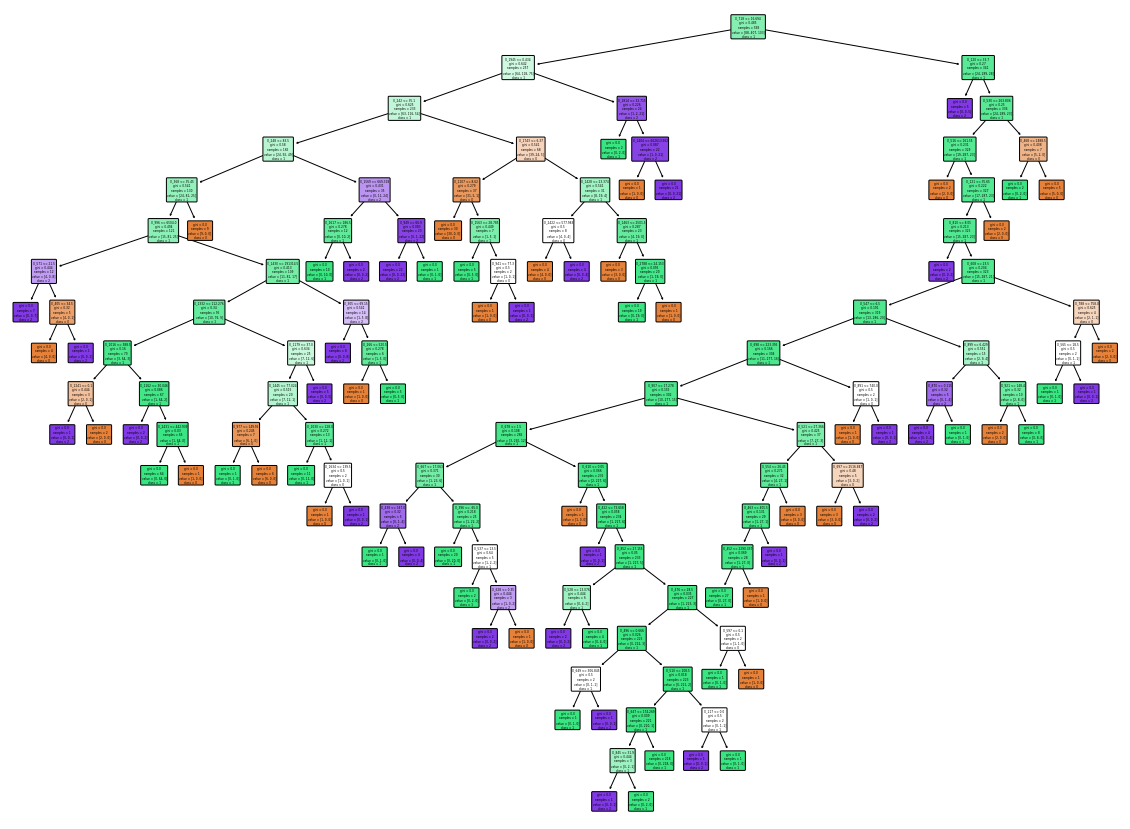

In [ ]:
"""
특성 중요도
해당 지표 : 0 ~ 1
0 = 특성이 전혀 작용하지 않았음
1 = 완전하게 작용했음
"""
import seaborn as sns
import numpy as np
%matplotlib inline

# feature별 importance 매핑
features = np.array(list(train_x.columns))
for name, value in zip(features, model.feature_importances_):
    print('{} : {:.3f}'.format(name, value))

# feature importance를 column 별로 시각화 하기 
sns.barplot(x = model.feature_importances_, y = features)

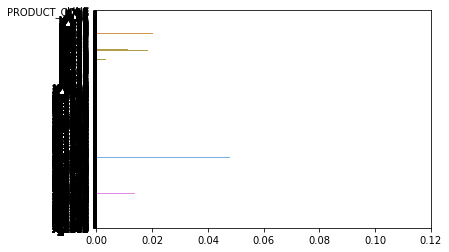

***  
# RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=37).fit(train_x, train_y)

In [ ]:
f_i = pd.Series(RF.feature_importances_, index = train_x.columns)
f_i = f_i.sort_values(ascending = False)

# f_i.sort_values().plot(kind = "barh", figsize = (8, 600))
# plt.show()

In [ ]:
features_df = pd.DataFrame(f_i, columns = ["importance"])

remove_Xs = list(features_df.where(features_df["importance"] == 0).dropna().transpose().columns)
re_train_x = train_x.copy()
re_train_x.drop(remove_Xs, axis = 1, inplace = True)


In [ ]:
RF2 = RandomForestClassifier(random_state=37).fit(re_train_x, train_y)

In [ ]:
f_i = pd.Series(RF2.feature_importances_, index = re_train_x.columns)
f_i = f_i.sort_values(ascending = False)

features_df = pd.DataFrame(f_i, columns = ["importance"])

remove_Xs = list(features_df.where(features_df["importance"] == 0).dropna().transpose().columns)
re2_train_x = re_train_x.copy()
re2_train_x.drop(remove_Xs, axis = 1, inplace = True)
re_test_x = test_x.copy()
re_test_x.drop(remove_Xs, axis = 1, inplace = True)

# f_i.sort_values().plot(kind = "barh", figsize = (8, 600))
# plt.show()

RF3 = RandomForestClassifier(random_state=37).fit(re2_train_x, train_y)

In [ ]:
model = RandomForestClassifier(random_state = 37).fit(re2_train_x, train_y)

In [ ]:
submit = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LG Aimers Dacon/open/sample_submission.csv")

preds = model.predict(re_test_x)
submit['Y_Class'] = preds

submit.to_csv('baseline_submission.csv', index=False)